In [2]:
import sys
import csv
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import subprocess
import re
from numpy import random
from numpy import linalg
import copy
import datetime
from shapely import geometry
from shapely.geometry import Point, Polygon
from shapely.ops import transform

In [3]:
def plot_polys(polys):
  for poly in polys:
    plt.plot(*poly.exterior.xy)
  plt.grid()
  plt.gca().set_aspect("equal")

class Shelf:
  def __init__(self, diameter, height):
    vertices = []
    r = diameter/2
    for i in range(12):
      vertices.append((r*np.cos(i*np.pi/6), r*np.sin(i*np.pi/6)))
    self.shape = Polygon(vertices)
    self.boundary_coord_list_xy = self.shape.boundary.coords
    self.height = height
    self.items = []
  
  def place_item(self, item):
    self.items.append(item)
  
  def in_shelf(self, item):
    return self.shape.contains(item)
  
  def item_shapes(self):
    return [p.shape for p in self.items]

class Rectangle:
  def __init__(self, a, b, height):
    self.height = height
    self.a = a
    self.b = b
    self.shape = ()
    self.origin = ()
  
  def set_position(self, origin: Point, tall: bool):
    self.origin = origin
    if tall:
      self.shape = Polygon([(origin.x - self.b/2, origin.y - self.a/2),
                            (origin.x - self.b/2, origin.y + self.a/2),
                            (origin.x + self.b/2, origin.y + self.a/2),
                            (origin.x + self.b/2, origin.y - self.a/2)])
    else:
      self.shape = Polygon([(origin.x - self.a/2, origin.y - self.b/2),
                            (origin.x - self.a/2, origin.y + self.b/2),
                            (origin.x + self.a/2, origin.y + self.b/2),
                            (origin.x + self.a/2, origin.y - self.b/2)])

class Circle:
  def __init__(self, diameter, height):
    self.d = diameter
    self.height = height
    self.shape = ()
    self.origin = ()
  
  def set_position(self, origin: Point):
    self.origin = origin
    self.shape = origin.buffer(self.d/2)

def line_between(p1: Point, p2: Point):
  slope = (p2.y - p1.y)/(p2.x - p1.x)
  intercept = p1.y - slope*p1.x
  return lambda x : slope*x + intercept

def on_boundary(point: Point, boundary, precision=5):
  '''
  Given a point and a boundary, return whether or not the point is on the boundary
  to a given precision (default: 10^-5).
  '''
  coords = boundary.coords
  dists = [np.sqrt((point.x - coords[i].x)**2 + (point.y - coords[i].y)**2) for i in range(len(coords))]
  closest_point = dists.remove(min(dists))
  second_closest_point = dists.remove(min(dists))
  boundary_slope = (closest_point.y - second_closest_point.y)/(closest_point.x - second_closest_point.x)
  boundary_intercept = closest_point.y - boundary_slope*closest_point.x
  return abs(point.y - (boundary_slope*point.x + boundary_intercept)) <= 10**(-precision) and boundary.contains(point)

def is_close(shelf, item):
  circ = shelf.bounds
  del circ[-1]
  D = range(circ.length) #number of points in shelf boundary
  if isinstance(item,Rectangle): # is rectangle
    vert=list(zip(*ex.shape.exterior.coords.xy))
    del vert[-1]
  else: # is circle
    vert = item.shape.bounds
    del vert[-1]
  for v in vert:
      i=0
      for p in circ:
        D[i]=np.sqrt((v[1]-p[1])^2+(v[2]-p[2])^2)
        i=i+1
      closest1=D.pop(D.index(min(D)))
      closest2=D.index(min(D)) #if more than 2 equidistance points impossible to violate boundary ...?
      #interpolate part :/
      # if distance less than allowance return true else false

def find_index_of_closest_point_to(p: Point, list_of_points):
  return min(range(len(list_of_points)), key = lambda i : abs(list_of_points[i][0] - p.x)**2 + abs(list_of_points[i][1] - p.y)**2)

In [4]:
SHELF_DIAMETER = 28 # in
SHELF_HEIGHT = 2 # in

CATALOG = {"Sarah Palette": Rectangle(13.25, 8.75, 0.75),
           "Florence Palatte": Rectangle(10.25, 6.25, 0.75),
           "Imogene Brush Rest": Rectangle(4.25, 2, 0.75),
           "London Painter's Dish": Circle(4, 1.5),
           "Tierney Ray Palette": Rectangle(10.25, 8.75, 0.75),
           "Savanna Tool Holder": Circle(3, 4),
           "Tessa Trinket Dish": Circle(4, 1.5),
           "Paula Bud Vase": Circle(3.25, 3)}

s = Shelf(SHELF_DIAMETER, SHELF_HEIGHT)

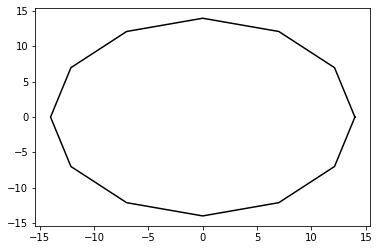

In [5]:
plt.plot(*s.shape.boundary.xy, 'k-')

In [6]:
print(*s.shape.boundary.coords)
ex= Rectangle(13.25, 8.75, 0.75)
ex.set_position(Point(0,0),True)
x=list(zip(*ex.shape.exterior.coords.xy))
del x[-1]
print(x)
for v in x:
  print(v[1])

(14.0, 0.0) (12.124355652982143, 6.999999999999999) (7.000000000000002, 12.12435565298214) (8.572527594031472e-16, 14.0) (-6.9999999999999964, 12.124355652982143) (-12.124355652982143, 6.999999999999999) (-14.0, 1.7145055188062944e-15) (-12.124355652982143, -6.9999999999999964) (-7.000000000000006, -12.124355652982137) (-2.5717582782094417e-15, -14.0) (7.000000000000002, -12.12435565298214) (12.124355652982137, -7.000000000000006) (14.0, 0.0)
[(-4.375, -6.625), (-4.375, 6.625), (4.375, 6.625), (4.375, -6.625)]
-6.625
6.625
6.625
-6.625


In [7]:
print(*s.shape.boundary.coords)
ex= Rectangle(13.25, 8.75, 0.75)
ex.set_position(Point(0,0),True)
print(list(zip(*ex.shape.exterior.coords.xy)))


(14.0, 0.0) (12.124355652982143, 6.999999999999999) (7.000000000000002, 12.12435565298214) (8.572527594031472e-16, 14.0) (-6.9999999999999964, 12.124355652982143) (-12.124355652982143, 6.999999999999999) (-14.0, 1.7145055188062944e-15) (-12.124355652982143, -6.9999999999999964) (-7.000000000000006, -12.124355652982137) (-2.5717582782094417e-15, -14.0) (7.000000000000002, -12.12435565298214) (12.124355652982137, -7.000000000000006) (14.0, 0.0)
[(-4.375, -6.625), (-4.375, 6.625), (4.375, 6.625), (4.375, -6.625), (-4.375, -6.625)]


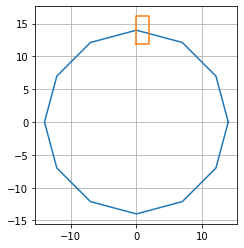

In [11]:
s = Shelf(SHELF_DIAMETER, SHELF_HEIGHT)
boundary = s.boundary_coord_list_xy

PRODUCT_OBJS = list(CATALOG.values())
n = 50
orders = [copy.deepcopy(PRODUCT_OBJS[random.randint(0, len(PRODUCT_OBJS))]) for i in range(n)]

first_order = orders[0]
if type(first_order) is Rectangle:
  top_boundary_vertex = Point(0, SHELF_DIAMETER/2)
  index_of_boundary_vertex_right_to_top_boundary_vertex = find_index_of_closest_point_to(top_boundary_vertex, list(boundary))
  boundary_vertex_right_to_top_boundary_vertex_as_tuple = boundary[index_of_boundary_vertex_right_to_top_boundary_vertex]
  boundary_vertex_right_to_top_boundary_vertex = Point(boundary_vertex_right_to_top_boundary_vertex_as_tuple[0], boundary_vertex_right_to_top_boundary_vertex_as_tuple[1])
  y_position_top_edge = line_between(top_boundary_vertex, boundary_vertex_right_to_top_boundary_vertex)(first_order.b/2)
  first_order.set_position(Point(first_order.b/2, y_position_top_edge), True)
else:
  # If item is not a rectangle, it's a circle
  first_order.set_position(Point(0, SHELF_DIAMETER/2 - first_order.d/2))
  ## TODO: this doesn't work bc I am a dumbass,
  # right_side_boundary_tangent_point_to_circle = np.linalg.solve([[1, -1/np.sqrt(3)], [1/np.sqrt(3), 1]], [0, SHELF_DIAMETER/2])
  # dy = np.sqrt((first_order.d/2)**2 + right_side_boundary_tangent_point_to_circle[0]**2 + right_side_boundary_tangent_point_to_circle[1]**2)
  # first_order.set_position(Point(0, SHELF_DIAMETER/2 - dy))
s.place_item(orders.pop(0))
plot_polys([s.shape]+s.item_shapes())

In [14]:
print(s.items[0].origin)
print(s.items[0].a)
print(s.items[0].b)

POINT (1 14)
4.25
2
